In [212]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

LOAD DATA

In [213]:

train_cat=pd.read_excel(r'C:\Users\Lenovo\Downloads\widsdatathon2025\TRAIN\TRAIN_CATEGORICAL_METADATA.xlsx')
train_quant=pd.read_excel(r'C:\Users\Lenovo\Downloads\widsdatathon2025\TRAIN\TRAIN_QUANTITATIVE_METADATA.xlsx')
test_cat=pd.read_excel(r'C:\Users\Lenovo\Downloads\widsdatathon2025\TEST\TEST_CATEGORICAL.xlsx')
test_quant=pd.read_excel(r'C:\Users\Lenovo\Downloads\widsdatathon2025\TEST\TEST_QUANTITATIVE_METADATA.xlsx')

In [252]:
train_data=pd.concat([train_cat,train_quant],ignore_index=True)
test_data=pd.concat([test_cat,test_quant],ignore_index=True)

PREPROCESSING

In [271]:
# Drop  unnecessary columns if they exist
drop_cols=["Basic_Demos_Enroll_Year","PreInt_Demos_Fam_Child_Ethnicity","Basic_Demos_Study_Site","Barratt_Barratt_P1_Edu","Barratt_Barratt_P1_Occ","Barratt_Barratt_P2_Edu","Barratt_Barratt_P2_Occ","MRI_Track_Scan_Location"]
train_data=train_data.drop(drop_cols,errors='ignore',axis=1)
train_data.shape

(2426, 20)

In [270]:
test_data=test_data.drop(columns=drop_cols,errors='ignore',axis=1)
test_data.shape

(608, 20)

In [272]:
#Check for data distribution/skewnsess
train_data.describe()
test_cat.describe()

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
count,304.000000,304.000000,301.000000,298.000000,304.000000,303.000000,303.000000,268.000000,262.000000
mean,2022.197368,4.009868,0.355482,2.231544,3.638158,19.128713,29.389439,18.458955,35.763359
std,0.494718,0.099012,0.665741,3.392914,0.481326,2.680553,16.484193,3.087093,11.978162
min,2019.000000,4.000000,0.000000,0.000000,3.000000,3.000000,0.000000,3.000000,0.000000
25%,2022.000000,4.000000,0.000000,0.000000,3.000000,18.000000,25.000000,18.000000,30.000000
50%,2022.000000,4.000000,0.000000,0.000000,4.000000,21.000000,35.000000,18.000000,40.000000
75%,2022.000000,4.000000,1.000000,3.000000,4.000000,21.000000,45.000000,21.000000,45.000000
max,2023.000000,5.000000,3.000000,11.000000,4.000000,21.000000,45.000000,21.000000,45.000000


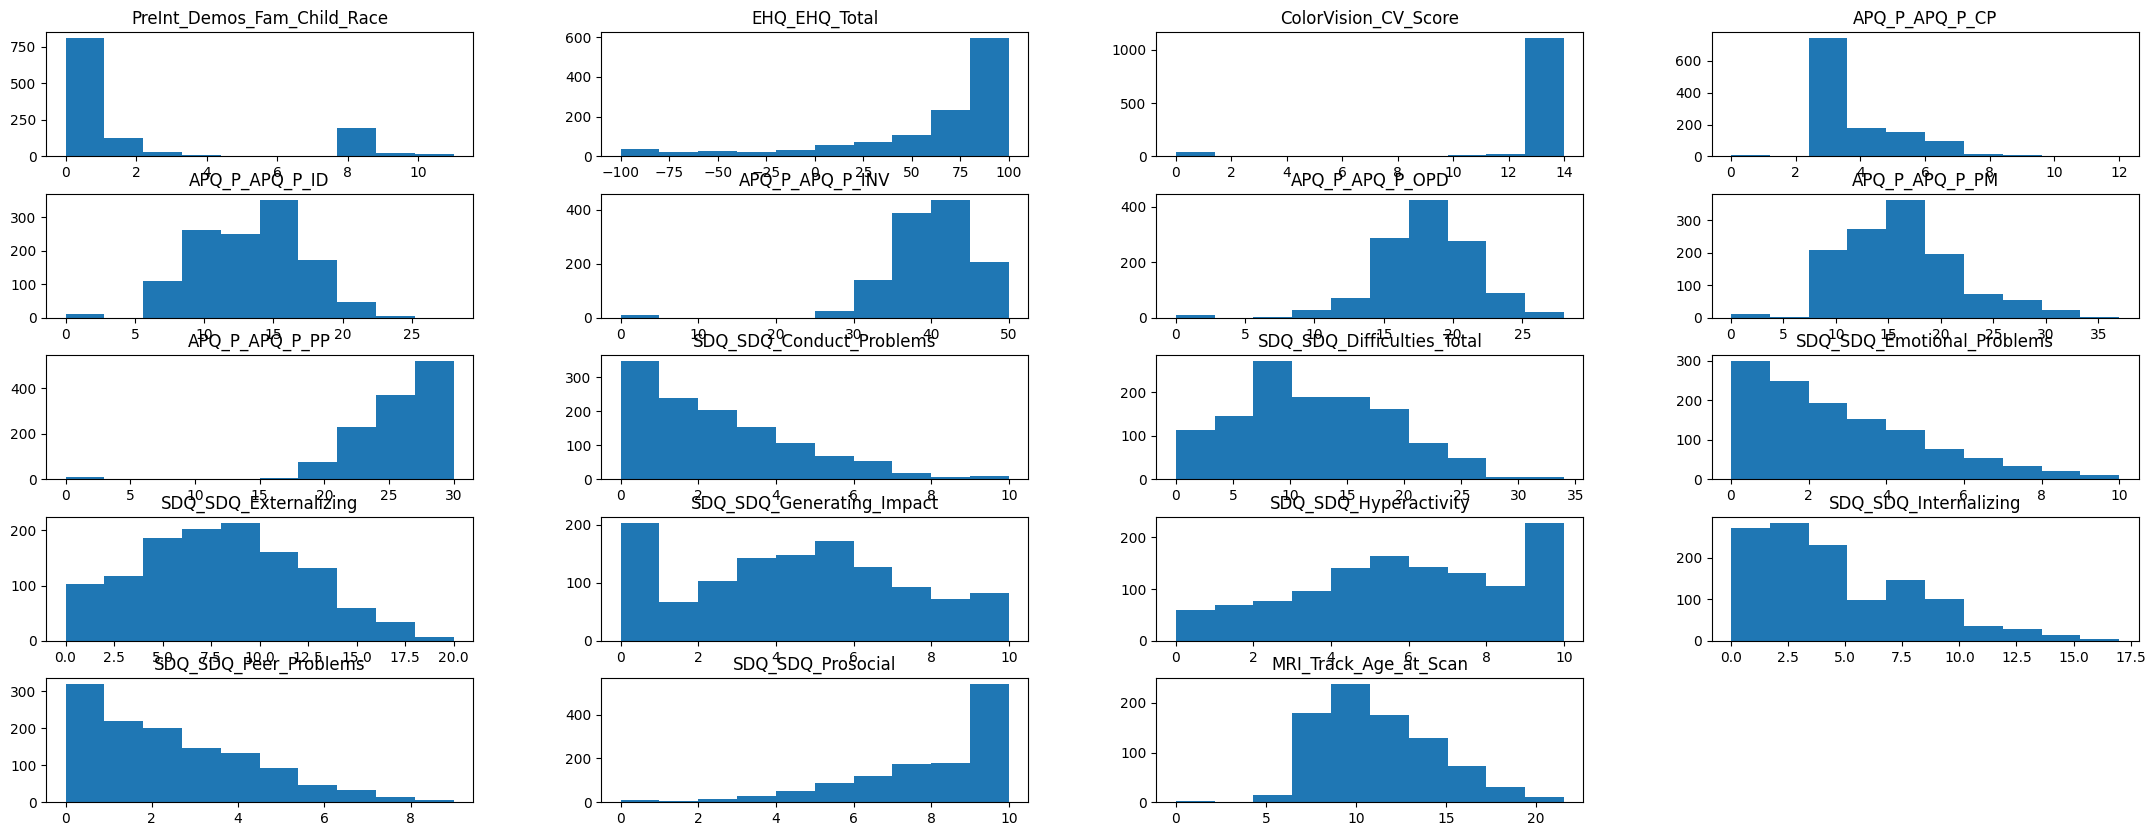

In [273]:
train_data.hist(figsize=(27, 10), bins=10, grid=False)
plt.show()

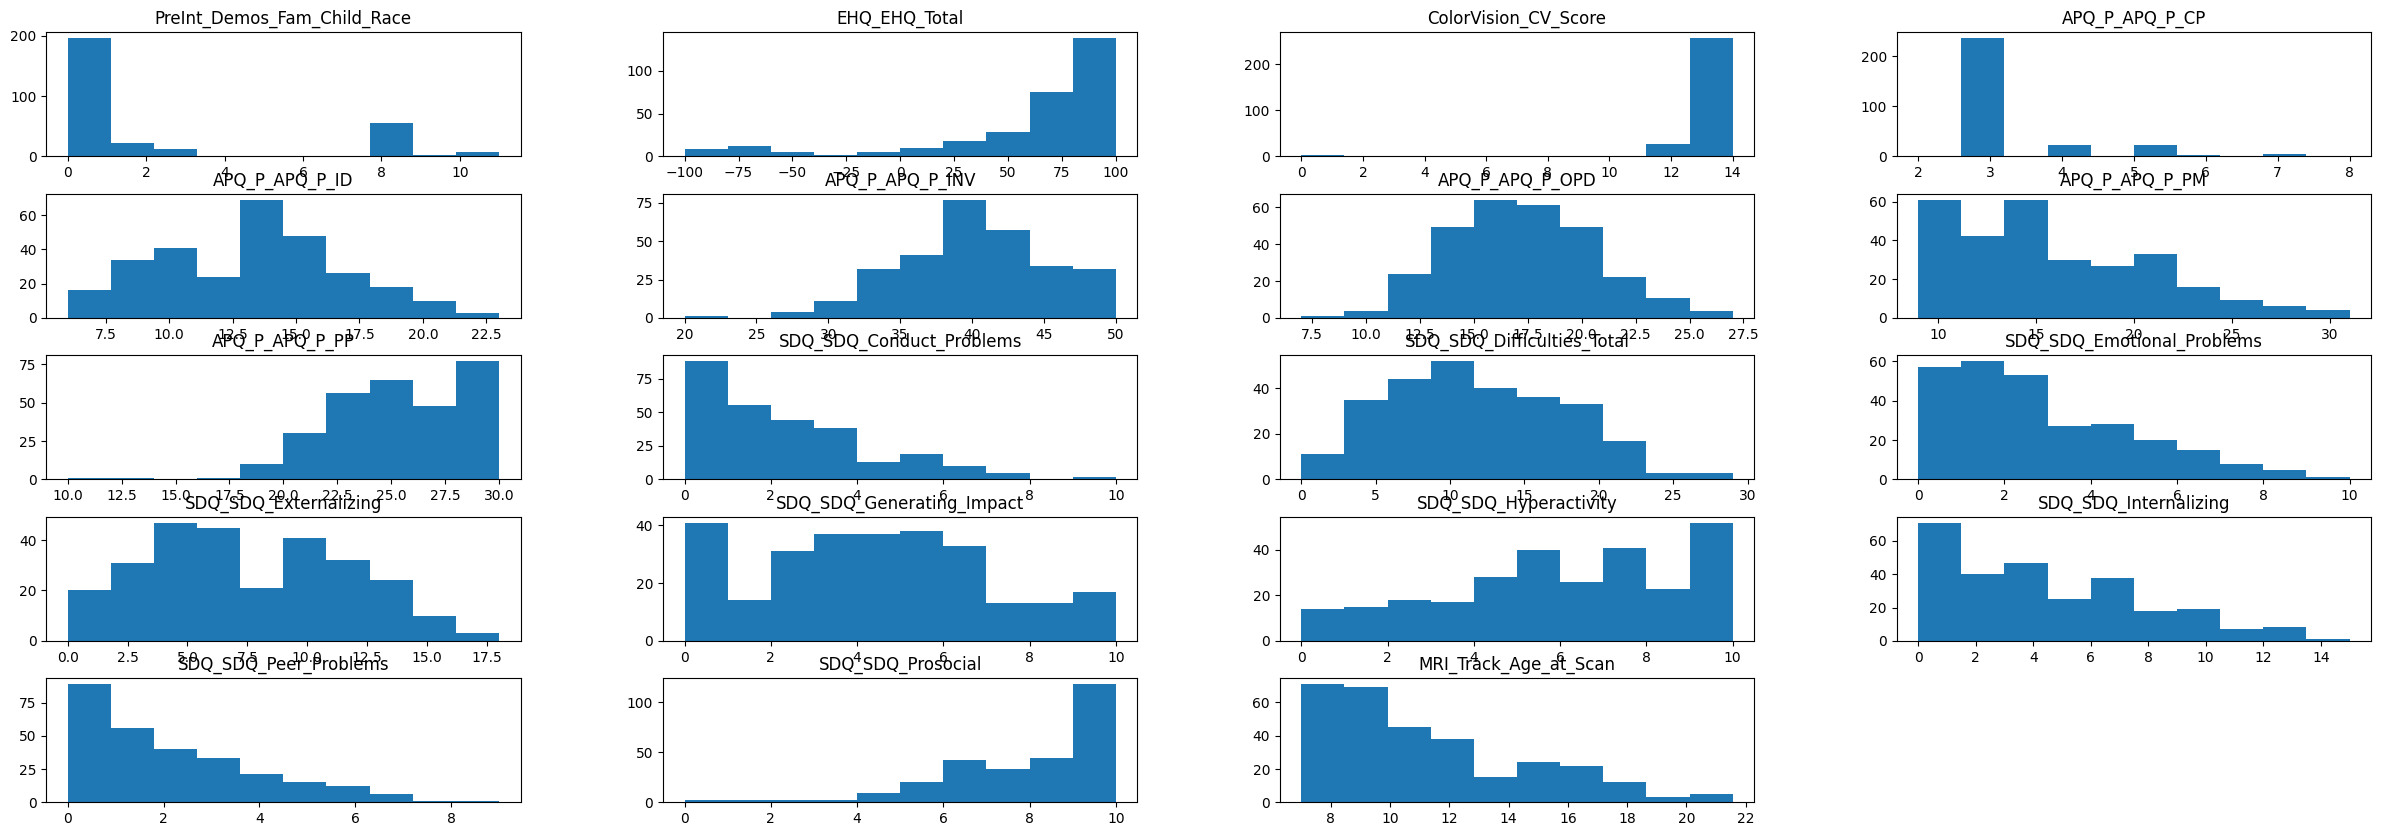

In [274]:
test_data.hist(figsize=(30, 10), bins=10, grid=False)
plt.show()

<Axes: >

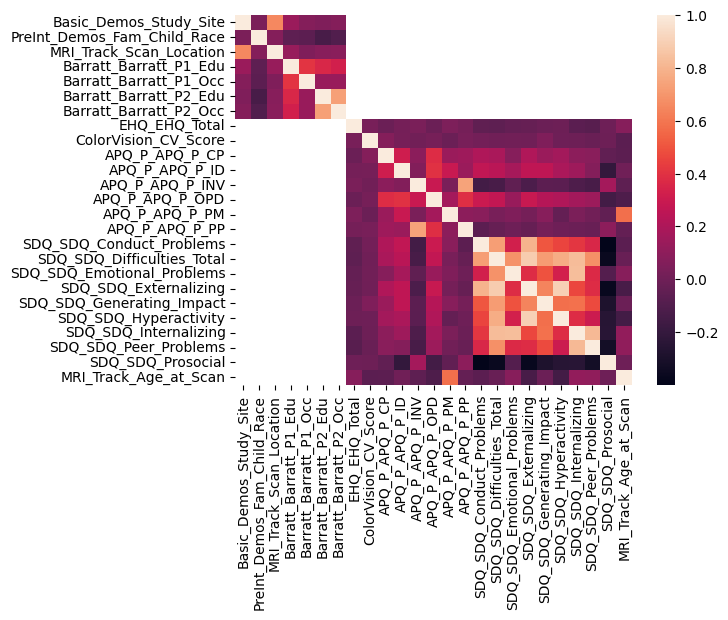

In [ ]:
#Check for correlation
corr_train = train_data.select_dtypes(include=['number']).corr()
sns.heatmap(corr_train)
#Drop Basic_Demos_Study_Site ,Barratt_P1_Edu, Barratt_P1_Occ, Barratt_P2_Edu, Barratt_P2_Occ,MRI_Track_Scan_Location

In [275]:
#Check for missing values and impute
test_data.isnull().sum()
train_data.isnull().sum()


participant_id                    0
PreInt_Demos_Fam_Child_Race    1213
EHQ_EHQ_Total                  1213
ColorVision_CV_Score           1213
APQ_P_APQ_P_CP                 1213
APQ_P_APQ_P_ID                 1213
APQ_P_APQ_P_INV                1213
APQ_P_APQ_P_OPD                1213
APQ_P_APQ_P_PM                 1213
APQ_P_APQ_P_PP                 1213
SDQ_SDQ_Conduct_Problems       1213
SDQ_SDQ_Difficulties_Total     1213
SDQ_SDQ_Emotional_Problems     1213
SDQ_SDQ_Externalizing          1213
SDQ_SDQ_Generating_Impact      1213
SDQ_SDQ_Hyperactivity          1213
SDQ_SDQ_Internalizing          1213
SDQ_SDQ_Peer_Problems          1213
SDQ_SDQ_Prosocial              1213
MRI_Track_Age_at_Scan          1573
dtype: int64

In [ ]:
#Impute missing values- IMPORTANT
# Identify numerical and categorical columns
numerical_cols = train_data.select_dtypes(include=['number']).columns
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

# Using Iterative Imputer (like regression-based imputation)
iter_imputer = IterativeImputer()
train_data[numerical_cols] = iter_imputer.fit_transform(train_data[numerical_cols])

train_data.isnull().sum()


c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


participant_id                 0
PreInt_Demos_Fam_Child_Race    0
EHQ_EHQ_Total                  0
ColorVision_CV_Score           0
APQ_P_APQ_P_CP                 0
APQ_P_APQ_P_ID                 0
APQ_P_APQ_P_INV                0
APQ_P_APQ_P_OPD                0
APQ_P_APQ_P_PM                 0
APQ_P_APQ_P_PP                 0
SDQ_SDQ_Conduct_Problems       0
SDQ_SDQ_Difficulties_Total     0
SDQ_SDQ_Emotional_Problems     0
SDQ_SDQ_Externalizing          0
SDQ_SDQ_Generating_Impact      0
SDQ_SDQ_Hyperactivity          0
SDQ_SDQ_Internalizing          0
SDQ_SDQ_Peer_Problems          0
SDQ_SDQ_Prosocial              0
MRI_Track_Age_at_Scan          0
dtype: int64

In [ ]:
# Identify numerical and categorical columns -IMPORTANT
numerical_cols = test_data.select_dtypes(include=['number']).columns
categorical_cols = test_data.select_dtypes(include=['object', 'category']).columns

# Using Iterative Imputer (like regression-based imputation)
iter_imputer = IterativeImputer()
test_data[numerical_cols] = iter_imputer.fit_transform(test_data[numerical_cols])

test_data.isnull().sum()

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


participant_id                 0
PreInt_Demos_Fam_Child_Race    0
EHQ_EHQ_Total                  0
ColorVision_CV_Score           0
APQ_P_APQ_P_CP                 0
APQ_P_APQ_P_ID                 0
APQ_P_APQ_P_INV                0
APQ_P_APQ_P_OPD                0
APQ_P_APQ_P_PM                 0
APQ_P_APQ_P_PP                 0
SDQ_SDQ_Conduct_Problems       0
SDQ_SDQ_Difficulties_Total     0
SDQ_SDQ_Emotional_Problems     0
SDQ_SDQ_Externalizing          0
SDQ_SDQ_Generating_Impact      0
SDQ_SDQ_Hyperactivity          0
SDQ_SDQ_Internalizing          0
SDQ_SDQ_Peer_Problems          0
SDQ_SDQ_Prosocial              0
MRI_Track_Age_at_Scan          0
dtype: int64